<a href="https://colab.research.google.com/github/beccalunch/adv-ml-playground/blob/main/crucible/granny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests

CRUCIBLE_API_KEY = "hzVUEuc8pfP78HQaWJcItf7iYahhK9O3"


artifacts = ["reference.png"]

for artifact in artifacts:
    url = f"https://crucible.dreadnode.io/api/artifacts/granny/{artifact}"
    headers={"Authorization": CRUCIBLE_API_KEY}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        with open(artifact, "wb") as file:
            file.write(response.content)
        print(f"{artifact} was successfully downloaded")
    else:
        print(f"Failed to download {artifact}")

reference.png was successfully downloaded


In [2]:
import base64

with open('reference.png', 'rb') as f:
    reference = base64.b64encode(f.read()).decode()

In [3]:
def query(input_data):
    response = requests.post(
        "https://granny.crucible.dreadnode.io/score",
        headers={"Authorization": "hzVUEuc8pfP78HQaWJcItf7iYahhK9O3"},
        json={"data": input_data}
    )
    return response.json()

query(reference)['output'][0]

[0.28575703501701355, 'timber wolf']

We want to specifically get it to predict a granny smith apple instead of a wolf. I think we can do this with a pixel attack - especially given the challenge's hint to be discrete.

Let's see if ART has something we can use.

First, we have to figure out which model is doing this.

Can we rotate it?

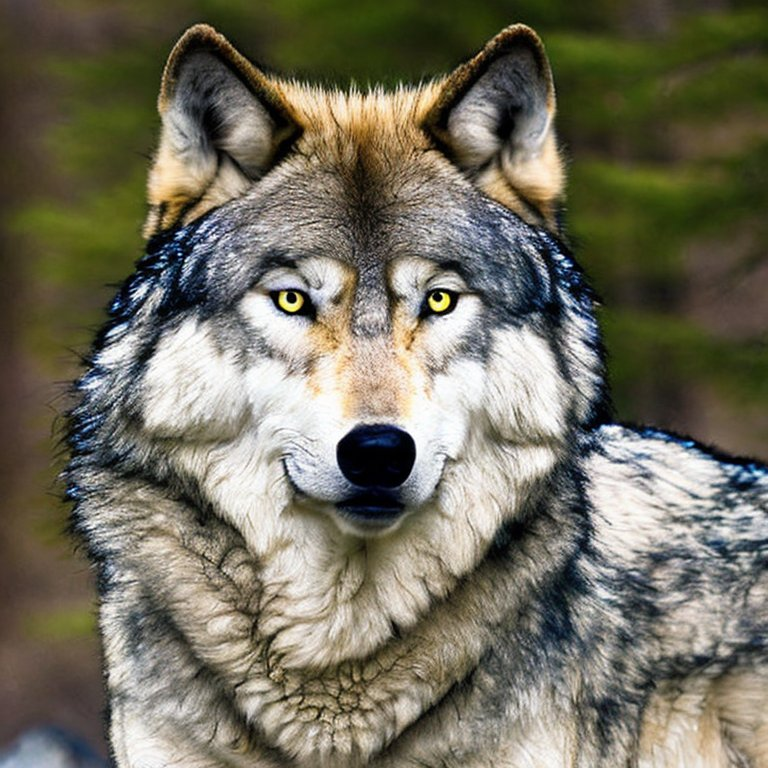

In [4]:
from PIL import Image
img = Image.open('reference.png')
img

In [5]:
res = {}

for i in [0, 90, 180, 270, 360]:
  print(f"rotating image {i} degrees")
  rotated = img.rotate(i)
  # save rotated image
  path = f'img_rotated_{i}.png'
  rotated.save(path)

  with open(path, 'rb') as f:
    image = base64.b64encode(f.read()).decode()

  res[i] = query(image)['output'][0]

res

rotating image 0 degrees
rotating image 90 degrees
rotating image 180 degrees
rotating image 270 degrees
rotating image 360 degrees


{0: [0.28575703501701355, 'timber wolf'],
 90: [0.04797955974936485, 'timber wolf'],
 180: [0.050902292132377625, 'timber wolf'],
 270: [0.09678452461957932, 'timber wolf'],
 360: [0.28575703501701355, 'timber wolf']}

In [6]:
!pip install timm

In [7]:
import torch
import timm
from PIL import Image
from torchvision import transforms


# Function to load an image and transform it for model inference
def load_and_transform_image(image_path, rotation=None):
    transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    image = Image.open(image_path).convert("RGB")
    if rotation is not None:
      image = image.rotate(rotation)
    return transform(image).unsqueeze(0)  # Add batch dimension


# Function to perform prediction using a specified model
def predict_image(model_name, image_tensor):
    model = timm.create_model(model_name, pretrained=True)
    model.eval()
    with torch.no_grad():
        logits = model(image_tensor)
    return logits.argmax(dim=1), logits

The built in timm's mobilenet doesn't achieve the same score, but I wonder if we just pull it in from Keras and train it ourselves if that will do anything. Probably should have tried that first

`tinynet_e` is the model that gets the closest. Let's see how its scores compare with the rotated images.

In [108]:
import tensorflow as tf
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     alpha=1.4,
                                                     weights='imagenet',
                                                     classifier_activation="softmax")

pretrained_model.trainable = False

decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# function to preprocess the image for MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# extract labels from the probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

25009072/25009072 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [109]:
img = tf.io.read_file('/content/reference.png')
tf.strings.length(img)

<tf.Tensor: shape=(), dtype=int32, numpy=948006>

In [110]:
!ls -l /content/reference.png


-rw-r--r-- 1 root root 948006 Apr 28 20:07 /content/reference.png


In [111]:
# Try to open the file with Python to see if it's readable
try:
    with open('/content/reference.png', 'rb') as f:
        print(f.read(10))  # Read the first 10 bytes
except Exception as e:
    print("Error opening file:", e)


b'\x89PNG\r\n\x1a\n\x00\x00'


In [112]:
with tf.io.gfile.GFile('/content/reference.png', 'rb') as file:
    binary_data = file.read()

In [113]:
im = Image.open('/content/reference.png')
im.save('/content/reference.png')

In [114]:
from pathlib import Path
import imghdr

img_type = imghdr.what('/content/reference.png')
img_type

'png'

In [115]:
import matplotlib.pyplot as plt

In [116]:
image = tf.io.read_file('/content/reference.png')
image = tf.io.decode_png(image)
image

<tf.Tensor: shape=(768, 768, 3), dtype=uint8, numpy=
array([[[ 76,  63,  54],
        [ 76,  63,  54],
        [ 76,  63,  54],
        ...,
        [ 29,  33,  10],
        [ 29,  33,  10],
        [ 28,  32,   9]],

       [[ 76,  63,  54],
        [ 75,  62,  53],
        [ 76,  63,  54],
        ...,
        [ 29,  33,  10],
        [ 28,  32,   9],
        [ 28,  32,   9]],

       [[ 75,  62,  53],
        [ 75,  62,  53],
        [ 75,  62,  53],
        ...,
        [ 29,  33,  10],
        [ 30,  34,  11],
        [ 30,  34,  11]],

       ...,

       [[132, 152, 177],
        [134, 154, 179],
        [138, 158, 182],
        ...,
        [192, 166, 133],
        [195, 169, 136],
        [197, 171, 138]],

       [[141, 161, 186],
        [144, 164, 189],
        [147, 167, 191],
        ...,
        [193, 164, 132],
        [193, 164, 132],
        [193, 164, 132]],

       [[146, 166, 191],
        [149, 169, 194],
        [153, 173, 197],
        ...,
        [193, 164, 13

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


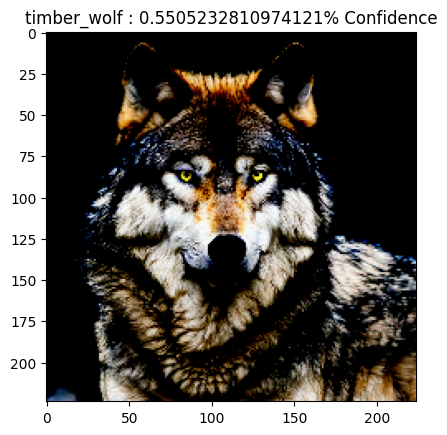

In [117]:
image = preprocess(image)
image_probs = pretrained_model.predict(image, steps=1)
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title(f'{image_class} : {class_confidence}% Confidence')
plt.show()

In [118]:
type(pretrained_model)

keras.src.models.functional.Functional

In [91]:
pip install --upgrade tensorflow adversarial-robustness-toolbox

ERROR: Operation cancelled by user


In [119]:
# Using ART to generate an example
import numpy as np
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier

from art.attacks.evasion import ProjectedGradientDescent


# tf.compat.v1.disable_eager_execution()
img = image.numpy()
clip_values = (-1, 1)
tf.config.run_functions_eagerly(True)
tf.experimental.numpy.experimental_enable_numpy_behavior()

classifier = TensorFlowV2Classifier(model=pretrained_model, loss_object=tf.keras.losses.CategoricalCrossentropy(), input_shape=(224, 224, 3), nb_classes=1000, clip_values=clip_values)

attack = ProjectedGradientDescent(estimator=classifier, eps=0.2, eps_step=0.04, max_iter=500, targeted=True)

@tf.function
def generate_adversarial():
    target = tf.constant([948])  # class index for granny apple
    return attack.generate(x=img, y=target)

# Generate the adversarial example
adv_example = generate_adversarial()

PGD - Batches: 0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


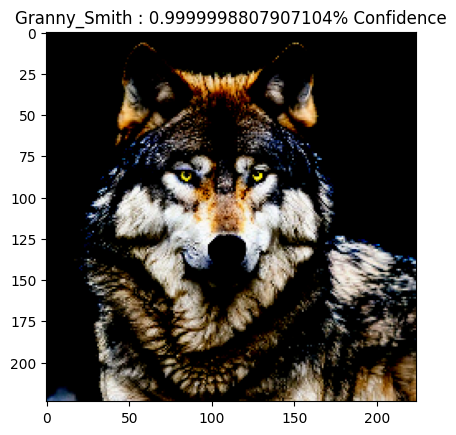

In [120]:
image_probs = pretrained_model.predict(adv_example, steps=1)
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title(f'{image_class} : {class_confidence}% Confidence')
plt.show()

In [121]:
# Assuming 'image_array' is your NumPy array containing the image data
# Remove extra dimensions if your array has shape (1, H, W, 3)

image_array = adv_example
if image_array.shape[0] == 1:
    image_array = image_array.squeeze(0)

# If your data is a float, scale and convert to uint8
if image_array.dtype == np.float32:
    image_array = (image_array * 255).astype(np.uint8)

img = Image.fromarray(image_array)
print(img)
img.save('/content/image.png')

<PIL.Image.Image image mode=RGB size=224x224 at 0x7DE911D7CE50>


In [122]:
with open('/content/image.png', 'rb') as f:
    reference = base64.b64encode(f.read()).decode()

def query(input_data):
    response = requests.post(
        "https://granny.crucible.dreadnode.io/score",
        headers={"Authorization": "hzVUEuc8pfP78HQaWJcItf7iYahhK9O3"},
        json={"data": input_data}
    )
    return response.json()

query(reference)['output']

[[0.012879367917776108, 'Airedale'],
 [0.01186943519860506, 'American alligator'],
 [0.011243348009884357, 'lacewing'],
 [0.010898225009441376, 'teddy'],
 [0.009847136214375496, 'spider web'],
 [0.009122663177549839, 'great grey owl'],
 [0.008440281264483929, 'barn spider'],
 [0.007635992486029863, 'hare'],
 [0.0066115474328398705, 'wolf spider'],
 [0.006600487045943737, 'peacock'],
 [0.006485907826572657, 'garden spider'],
 [0.006434640847146511, 'cardigan'],
 [0.00640774704515934, 'ant'],
 [0.006227730307728052, 'harvestman'],
 [0.005611327011138201, 'tick'],
 [0.0053989770822227, 'nematode'],
 [0.005345283076167107, 'Lakeland terrier'],
 [0.005085272714495659, 'shield'],
 [0.0050299097783863544, 'stole'],
 [0.004812973085790873, 'toy poodle'],
 [0.004786184523254633, 'miniature poodle'],
 [0.0046981461346149445, 'lynx'],
 [0.0046082776971161366, 'African crocodile'],
 [0.004596238490194082, 'jigsaw puzzle'],
 [0.004539418499916792, 'bib'],
 [0.004251113161444664, 'breastplate'],
 [0